In [0]:
# import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import pickle as pkl
import torch 
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset

from sklearn.metrics import accuracy_score

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# create a class specific to MNIST data
class MNIST_Dataset(Dataset):
    
    def __init__(self, X, y, transform = transforms.Compose(
                     [transforms.ToPILImage(), 
                      transforms.ToTensor(), 
                      transforms.Normalize(mean=(0.5,), std=(0.5,))])):
            
        self.transform = transform
        self.X = X.reshape((-1,128,128)).astype(np.uint8)[:,:,:,None]
        self.y = y
        
    @classmethod
    def from_train(cls, file_path_images, file_path_labels):
        train_images = pd.read_pickle(file_path_images)
        train_labels = pd.read_csv(file_path_labels)
        
        return cls(X=train_images, y=torch.from_numpy(train_labels['Label'].values))
        
    @classmethod
    def from_test(cls, file_path_images):
        test_images = pd.read_pickle(file_path_images)
        
        return cls(X=test_images, y=None)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.transform(self.X[idx])
        X = X.to(device)
        if self.y is not None:
            return X, self.y[idx].to(device)
        else:
            return X

In [3]:
# For google colab connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Get the data
train_data = pd.read_pickle('drive/My Drive/train_max_x') #File is too large, here's a workaround
#test_images = pd.read_pickle('drive/My Drive/test_max_x')
train_labels = pd.read_csv('drive/My Drive/train_max_y.csv')
number_train_images = int(train_data.shape[0] * 0.9)
print(number_train_images)

X_train = train_data[:number_train_images]
print(X_train.shape) #128 x 128, total size = 45,000
y_train = torch.from_numpy(train_labels['Label'][:number_train_images].values)
print(y_train.shape)

X_validation = train_data[number_train_images:]
y_validation = train_labels['Label'][number_train_images:].values

45000
(45000, 128, 128)
torch.Size([45000])


In [0]:
# Load the data into dataloaders
batch_size = 32

train_dataset = MNIST_Dataset(X_train, y_train)
train_dataset2 = MNIST_Dataset(X_train, None)
validation_dataset = MNIST_Dataset(X_validation, None)
test_dataset = MNIST_Dataset.from_test('drive/My Drive/test_max_x')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,                                      
                                           shuffle=True)

train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset2,
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                           shuffle=False)

In [0]:
# class for the neural network
class CNN(nn.Module):
    
    def __init__(self, input_dim, output_dim, dropout=0.5):
        
        super(CNN, self).__init__()
        
        # Layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 2),
            nn.Conv2d(32, 32, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 2),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(dropout))
        
        self.fc = nn.Linear(18432, output_dim)
     
    # For forward calculations
    def forward(self, x):
            
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
            
        return out
    

In [0]:
# Function to predict from data
def predict(model, data_loader):
    test_pred = torch.LongTensor()
    
    # go through data
    for i, data in enumerate(data_loader):
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [0]:
# Function to train the model
def train_model(model_class, train_loader, validation_loader, y_validation, dropout=0.3, epochs=25, criterion=nn.CrossEntropyLoss(), learning_rate=1e-3):
    input_dim = 128 * 128
    output_dim = 10
    model = model_class(input_dim, output_dim, dropout).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    losses = []
    validation_score_per_epoch = []
    training_score_per_epoch = []
    print("Beginning training...\n\n")

    # Begin training loop
    for epoch in range(epochs):
        
        # Go through data
        for idx, data in enumerate(train_loader, 0):
            inputs, labels = data
            labels = labels.to(dtype=torch.long)
            data = data[0].view(data[0].shape[0], -1)

            optimizer.zero_grad()
            outputs = model(inputs)  

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # calculate metrics
        model.eval()

        training_predictions = predict(model, train_loader2).numpy()
        training_score_per_epoch.append(accuracy_score(y_train, training_predictions))
        validation_predictions = predict(model, validation_loader).numpy()
        validation_score_per_epoch.append(accuracy_score(y_validation, validation_predictions))
        
        model.train()
        
        losses.append(loss)
    print('[Finished Training] Training Score: %.4f Validation Score: %.4f Loss: %.4f' % (training_score_per_epoch[-1],validation_score_per_epoch[-1], losses[-1]))
    return model, losses, validation_score_per_epoch, training_score_per_epoch

In [9]:
# train the model 
summary = {'model' : [], 'loss' : [], 'validation_score' : [], 'training_score' : []}
    
model, loss, val_score, train_score = train_model(CNN, train_loader, validation_loader, y_validation, dropout=0.3, epochs=25)
summary['model'].append(model)
summary['loss'].append(loss)
summary['validation_score'].append(val_score)
summary['training_score'].append(train_score)


Beginning training...


[Finished Training] Training Score: 0.1787 Validation Score: 0.8886 Loss: 0.1940


In [0]:
loss2 = loss
model2 = model
val_score2 = val_score
train_score2 = train_score

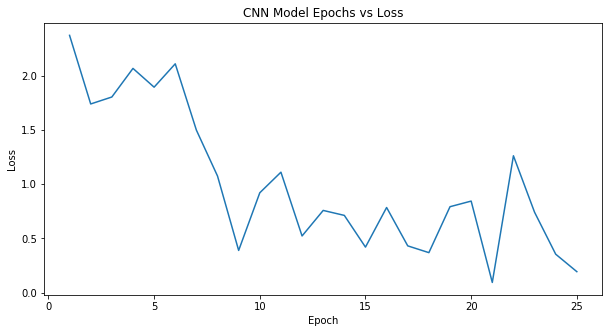

In [23]:
# Plot some data
plt.figure(figsize=(10,5))
numEpochs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14
             ,15,16,17,18,19,20,21,22,23,24,25]
plt.plot(numEpochs, loss)
plt.title('CNN Model Epochs vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
axes = plt.gca()
plt.show()

In [24]:
print(loss)

[tensor(2.3710, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.7389, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8030, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.0665, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8936, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.1089, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4981, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.0750, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.3897, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.9208, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1104, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.5228, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.7581, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.7124, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.4202, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.7852, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.4317, device='cuda:0', grad_fn

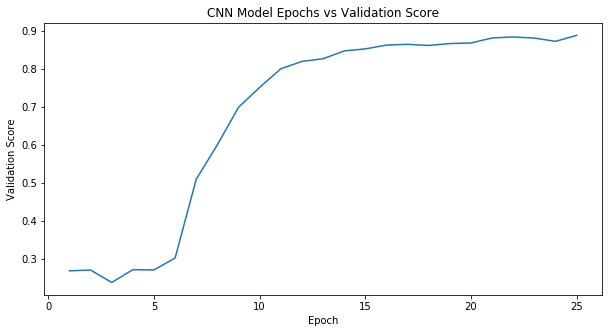

In [25]:
# Plot some more data
plt.figure(figsize=(10,5))
plt.plot(numEpochs, val_score)
plt.title('CNN Model Epochs vs Validation Score')
plt.ylabel('Validation Score')
plt.xlabel('Epoch')
axes = plt.gca()
plt.show()

In [26]:
print(train_score)
print(type(train_score))

[0.2636, 0.26715555555555554, 0.23357777777777777, 0.26868888888888887, 0.2677111111111111, 0.2558888888888889, 0.21637777777777778, 0.19953333333333334, 0.19064444444444445, 0.18064444444444444, 0.17542222222222223, 0.17773333333333333, 0.17457777777777778, 0.17584444444444444, 0.1766, 0.17444444444444446, 0.17608888888888888, 0.1751111111111111, 0.17675555555555555, 0.1768888888888889, 0.17502222222222222, 0.1746888888888889, 0.1739111111111111, 0.17586666666666667, 0.1786888888888889]
<class 'list'>


In [0]:
train_score_arr = np.asarray(train_score)
np_ones = np.ones(25)

In [28]:
np_ones

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [0]:
train_acc = np.subtract(np_ones, train_score_arr)

In [30]:
print(train_acc)

[0.7364     0.73284444 0.76642222 0.73131111 0.73228889 0.74411111
 0.78362222 0.80046667 0.80935556 0.81935556 0.82457778 0.82226667
 0.82542222 0.82415556 0.8234     0.82555556 0.82391111 0.82488889
 0.82324444 0.82311111 0.82497778 0.82531111 0.82608889 0.82413333
 0.82131111]


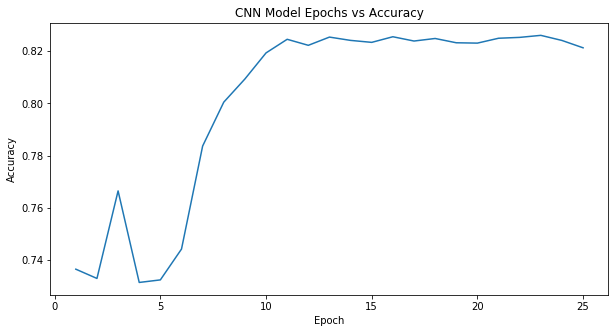

In [31]:
# Plot even more data
plt.figure(figsize=(10,5))
plt.plot(numEpochs, train_acc)
plt.title('CNN Model Epochs vs Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
axes = plt.gca()
plt.show()

In [0]:
#Final Accuracy = .88